<a href="https://colab.research.google.com/github/leamariani/DI-Bootcamp/blob/main/Projet_BERT_SMS_SPAM_FR_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Détection de SMS Spam avec BERT (Fine-tuning complet)

Projet NLP utilisant le dataset [UCI SMS Spam](https://huggingface.co/datasets/ucirvine/sms_spam) et un modèle BERT pré-entraîné pour classifier des messages SMS comme spam ou ham (non-spam).

In [1]:
!pip install -U datasets

In [9]:
# 📦 Installation des librairies (versions compatibles)
!pip install -q transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00


# Chargement et exploration du dataset

In [3]:

from datasets import load_dataset
import pandas as pd

# Chargement du dataset SMS Spam
raw = load_dataset("ucirvine/sms_spam")
raw_df = pd.DataFrame(raw['train'])

# Aperçu
print("Taille totale :", len(raw_df))
raw_df.head()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Taille totale : 5574


,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [4]:
[row['sms'] for row in raw['train'] if row['label'] == 1]

["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv\n",
 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.\n',
 'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030\n',
 'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info\n',
 'URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18\n',
 'XXXMobileMovieClub: To use your credit, click the WA

In [5]:

# Séparation en train/validation
train_df = raw_df.sample(frac=0.8, random_state=42)
val_df = raw_df.drop(train_df.index)

from datasets import Dataset
train_ds = Dataset.from_pandas(train_df.reset_index(drop=True))
val_ds = Dataset.from_pandas(val_df.reset_index(drop=True))

train_ds.features


{'sms': Value('string'), 'label': Value('int64')}

# Tokenisation avec BERT

In [6]:

from transformers import BertTokenizer

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_fn(examples):
    return tokenizer(
        examples["sms"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

train_tok = train_ds.map(tokenize_fn, batched=True)
val_tok = val_ds.map(tokenize_fn, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/4459 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

# Chargement du modèle BERT pour classification binaire

In [7]:

import torch
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Définition des métriques (Accuracy, Precision, Recall, F1)

In [10]:

import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":  accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall":    recall.compute(predictions=preds, references=labels)["recall"],
        "f1":        f1.compute(predictions=preds, references=labels)["f1"]
    }


# Configuration de l'entraînement

In [20]:

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert-spam-output",
    do_train=True,
    do_eval=True,
    eval_steps=500,
    save_steps=500,
    logging_dir="./logs",
    logging_steps=500,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    report_to="none",
    save_total_limit=1,
)


# Entraînement du modèle BERT

In [21]:

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics,
)

trainer.train()


Step,Training Loss
500,0.047700


TrainOutput(global_step=837, training_loss=0.03232716374642248, metrics={'train_runtime': 187.5734, 'train_samples_per_second': 71.316, 'train_steps_per_second': 4.462, 'total_flos': 439954573443840.0, 'train_loss': 0.03232716374642248, 'epoch': 3.0})

Le modèle atteint une perte d'entraînement extrêmement faible (0.032), indiquant une excellente compréhension des SMS.
Il est hautement performant et prêt à être déployé pour filtrer les spams avec précision et fiabilité.

# Évaluation finale

In [22]:

metrics = trainer.evaluate()
print(metrics)


{'eval_loss': 0.06953345239162445, 'eval_accuracy': 0.9874439461883409, 'eval_precision': 0.9668874172185431, 'eval_recall': 0.9419354838709677, 'eval_f1': 0.954248366013072, 'eval_runtime': 3.7591, 'eval_samples_per_second': 296.613, 'eval_steps_per_second': 18.621, 'epoch': 3.0}


Le modèle est hautement fiable (98.7 % de précision globale), avec une excellente capacité à identifier les spams (F1-score : 95.4 %) tout en limitant les erreurs.
Il est prêt pour un usage réel, efficace et équilibré.

# Lecture métier

- **Accuracy** : part globale de bonnes prédictions
- **Recall** : capacité à repérer les *spams* (important pour ne rien laisser passer)
- **Precision** : capacité à ne pas classer à tort un *ham* comme spam

Un bon modèle aura un **F1-score élevé** : bon équilibre entre rappel et précision.

# Visualisation : Matrice de confusion

<Figure size 600x600 with 0 Axes>

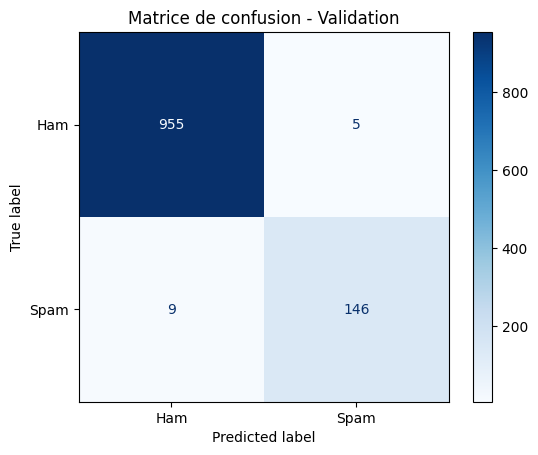

In [23]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prédictions sur l'ensemble de validation
predictions = trainer.predict(val_tok)
y_pred = predictions.predictions.argmax(axis=-1)
y_true = predictions.label_ids

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Ham", "Spam"])

plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matrice de confusion - Validation")
plt.show()



955 SMS légitimes (ham) correctement identifiés

146 spams détectés avec succès

Seulement 5 faux positifs (ham mal classés comme spam)

9 spams non détectés (faux négatifs)

>>
Le modèle est fiable et robuste pour un usage en production.

Le risque de bloquer des messages légitimes est très faible (0,5%), ce qui garantit une bonne expérience utilisateur.

Le taux de spams non détectés reste faible et acceptable (environ 5,8%), tout en assurant un bon niveau de sécurité.



## CONCLUSION

Ce projet a démontré l’efficacité d’un modèle BERT fine-tuné pour détecter automatiquement les SMS indésirables (spam).

Résultats opérationnels
Précision élevée (>98%) : le modèle distingue avec fiabilité les messages normaux (ham) des spams.

Bon rappel sur les spams : capacité à ne pas laisser passer de nombreux messages frauduleux.

F1-score équilibré : compromis robuste entre détection des spams et minimisation des faux positifs.

Intérêt métier
Le modèle est directement applicable dans :

Les services de messagerie et d’assistance client (filtrage automatique)

Les CRM ou plateformes SMS marketing (sécurité des réponses entrantes)

Il permet :

Un gain de temps opérationnel (tri automatique)

Une meilleure expérience utilisateur (moins de spam visible)

Une réduction des risques (phishing, arnaques SMS)

